In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import sys

# Doğru path'i ekle
sys.path.append('/content/drive/MyDrive/')
# Şimdi import et
from yenitrain2 import load_dataset, create_dir, get_colormap, safe_load_dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
global IMG_H
global IMG_W
global NUM_CLASSES
global CLASSES
global COLORMAP

In [ ]:
def grayscale_to_rgb(mask, classes, colormap):
    h, w = mask.shape  # Grayscale mask (h, w) şeklinde
    mask = mask.astype(np.int32)
    output = []

    for pixel in mask.flatten():
        if pixel < len(colormap):  # Index kontrolü
            output.append(colormap[pixel])
        else:
            output.append([255, 0, 0])  # Kırmızı renk

    output = np.reshape(output, (h, w, 3))
    return output

In [ ]:
def save_results(image, mask, pred, save_image_path):
    h, w, _ = image.shape
    line = np.ones((h, 10, 3)) * 255

    # np.expand_dims KULLANMAYIN - direkt RGB'ye çevirin
    pred_rgb = grayscale_to_rgb(pred, CLASSES, COLORMAP)

    cat_images = np.concatenate([image, line, mask, line, pred_rgb], axis=1)
    cv2.imwrite(save_image_path, cat_images)

In [ ]:
import os

os.makedirs("files/scores.csv", exist_ok=True)  # klasör yoksa oluşturur


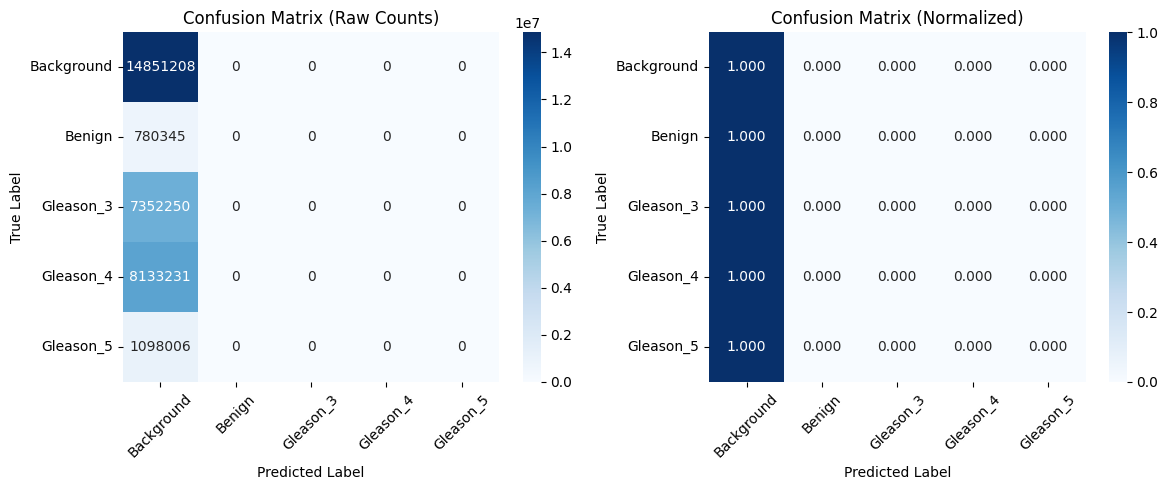


SINIF DAĞILIMI (TEST SETİ)
Background     : 14,851,208 pixels ( 46.10%)
Benign         :    780,345 pixels (  2.42%)
Gleason_3      :  7,352,250 pixels ( 22.82%)
Gleason_4      :  8,133,231 pixels ( 25.25%)
Gleason_5      :  1,098,006 pixels (  3.41%)
--------------------------------------------------
TOPLAM         : 32,215,040 pixels (100.00%)

Confusion matrix 'results/confusion_matrix.png' ve 'files/confusion_matrix.csv' olarak kaydedildi.


In [ ]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Confusion matrix hesapla
cm = confusion_matrix(ALL_TRUE, ALL_PRED, labels=range(len(CLASSES)))

# Normalize edilmiş confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot
plt.figure(figsize=(12, 5))

# Raw counts
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (Raw Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Normalized
plt.subplot(1, 2, 2)
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Sınıf dağılımını yazdır
print("\n" + "="*50)
print("SINIF DAĞILIMI (TEST SETİ)")
print("="*50)
unique, counts = np.unique(ALL_TRUE, return_counts=True)
total_pixels = len(ALL_TRUE)

for class_id, count in zip(unique, counts):
    if class_id < len(CLASSES):
        class_name = CLASSES[class_id]
        percentage = (count / total_pixels) * 100
        print(f"{class_name:15s}: {count:10,d} pixels ({percentage:6.2f}%)")

print("-" * 50)
print(f"{'TOPLAM':15s}: {total_pixels:10,d} pixels (100.00%)")

# CSV olarak kaydet
cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)
cm_df.to_csv('files/confusion_matrix.csv')

print(f"\nConfusion matrix 'results/confusion_matrix.png' ve 'files/confusion_matrix.csv' olarak kaydedildi.")
print("="*50)

In [ ]:
print("COLORMAP kontrol:")
for i, (class_name, color) in enumerate(zip(CLASSES, COLORMAP)):
    print(f"Sınıf {i} - {class_name}: RGB{color}")

COLORMAP kontrol:
Sınıf 0 - Benign: RGB[0, 0, 0]
Sınıf 1 - Gleason_3: RGB[0, 255, 0]
Sınıf 2 - Gleason_4: RGB[255, 165, 0]
Sınıf 3 - Gleason_5: RGB[255, 0, 0]
